In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
import cv2
from scipy.ndimage import sobel

In [9]:
image_dir = "/Users/rfalcao/Documents/FYP/ManualSegmentationAnns/cusp_images"
mask_dir = "/Users/rfalcao/Documents/FYP/ManualSegmentationAnns/masks"

In [10]:


# Helper to normalize a vector
def normalize(v):
    return v / np.linalg.norm(v)

def process_image(image_name):
    image_path = os.path.join(image_dir, image_name)
    mask_path = os.path.join(mask_dir, image_name.replace(".jpg", ".png"))

    # Load image and mask
    image = np.array(Image.open(image_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))
    binary_mask = (mask > 0).astype(np.uint8)

    num_labels, labels = cv2.connectedComponents(binary_mask)
    results = []

    for i in range(1, num_labels):  # Skip background
        component_mask = (labels == i).astype(np.uint8)
        y_idxs, x_idxs = np.nonzero(component_mask)
        coords = np.stack((x_idxs, y_idxs), axis=1)

        if coords.shape[0] < 2:
            continue

        # PCA
        pca = PCA(n_components=2)
        pca.fit(coords)
        direction = pca.components_[0]
        center = pca.mean_
        projections = coords @ direction
        tip_coord = coords[np.argmax(projections)]
        base_coord = coords[np.argmin(projections)]

        result = {
            "image_name": image_name,
            "label_id": i,
            "image": image,
            "component_mask": component_mask,
            "coords": coords,
            "centerline": (base_coord, tip_coord),
            "center": center,
            "pca_direction": direction
        }
        results.append(result)

    return results
def compute_sobel_magnitude(gray_img):
    dx = sobel(gray_img, axis=1)
    dy = sobel(gray_img, axis=0)
    magnitude = np.hypot(dx, dy)
    return magnitude


In [11]:
def trace_contrast_direction(center, perp_unit_vector, sobel_mag, max_radius=30, threshold=20):
    """
    Trace in +u and -u from center, sampling Sobel magnitudes.
    Returns the direction (unit vector) with higher contrast change.
    """
    center = np.array(center)
    best_grad = [0, 0]
    directions = [+1, -1]

    for idx, direction_sign in enumerate(directions):
        for r in range(1, max_radius):
            offset = direction_sign * r * perp_unit_vector
            sample_pt = np.round(center + offset).astype(int)

            x, y = sample_pt
            if y < 0 or y >= sobel_mag.shape[0] or x < 0 or x >= sobel_mag.shape[1]:
                break  # Out of bounds

            grad_value = sobel_mag[y, x]
            if grad_value > best_grad[idx]:
                best_grad[idx] = grad_value

            # Optional: stop early if a "significant" contrast is found
            if grad_value > threshold:
                break

    # Choose the direction with higher gradient
    if best_grad[0] >= best_grad[1]:
        return perp_unit_vector
    else:
        return -perp_unit_vector


In [21]:
all_cusps = []

for fname in os.listdir(image_dir)[:20]:
    

    if fname.endswith((".png", ".jpg", ".tif")):
        results = process_image(fname)
        all_cusps.extend(results)

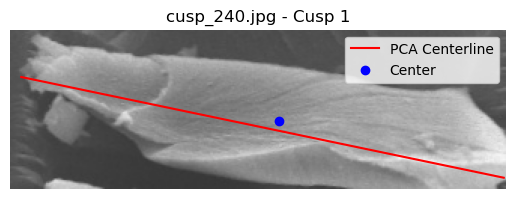

In [16]:
sample = all_cusps[1]
img = sample["image"]
base, tip = sample["centerline"]
center = sample["center"]

plt.imshow(img)
plt.plot([base[0], tip[0]], [base[1], tip[1]], 'r-', label='PCA Centerline')
plt.scatter(center[0], center[1], color='blue', label='Center')
plt.title(f"{sample['image_name']} - Cusp {sample['label_id']}")
plt.legend()
plt.axis('off')
plt.show()

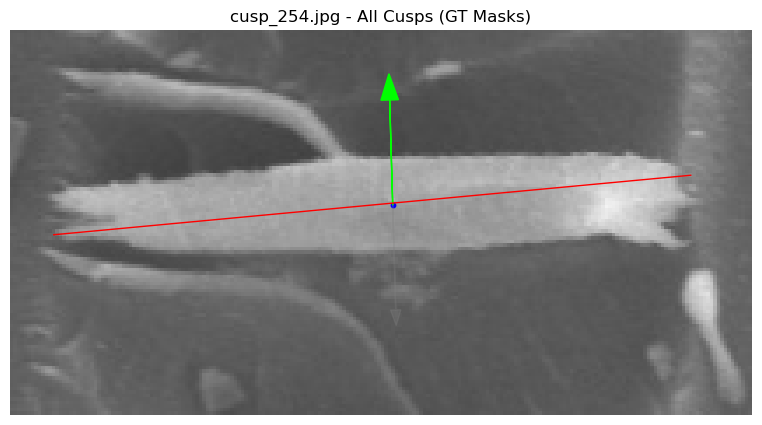

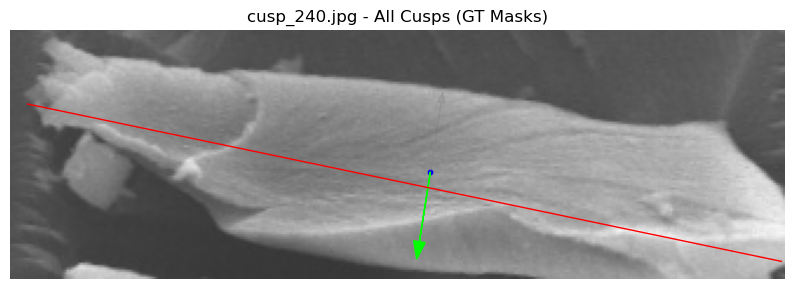

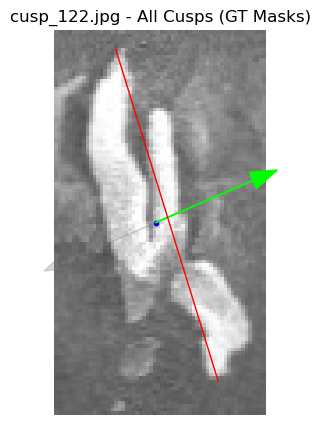

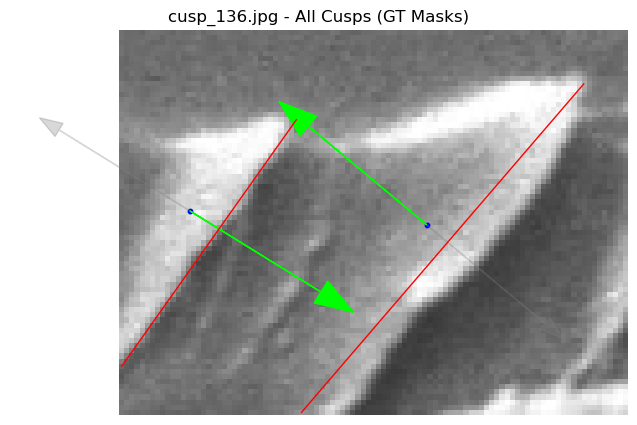

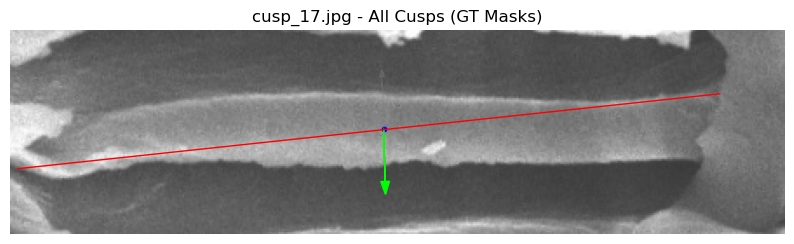

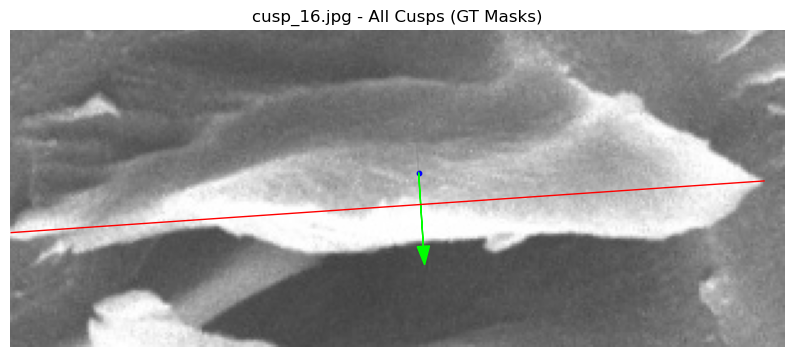

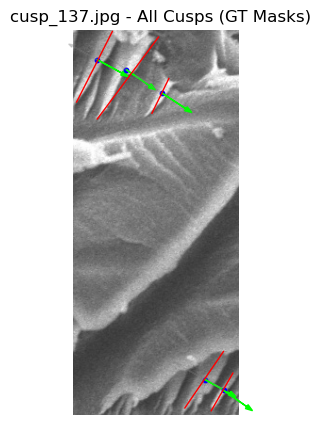

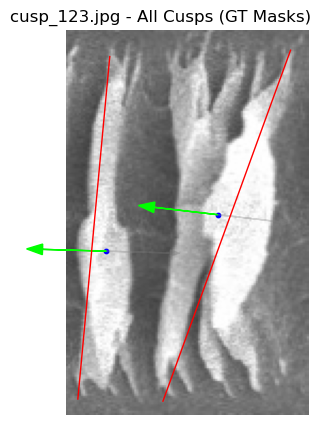

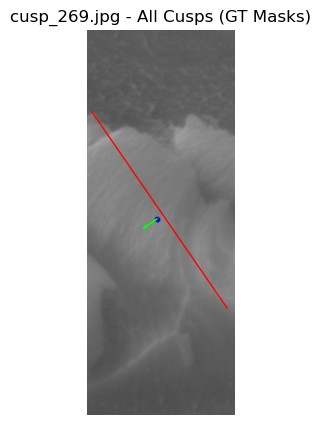

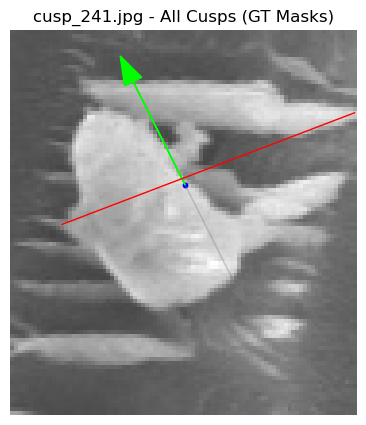

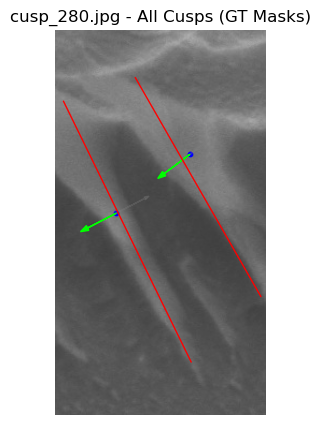

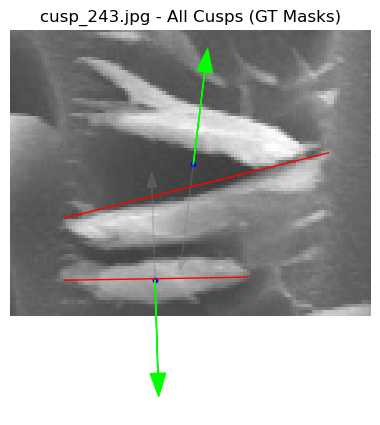

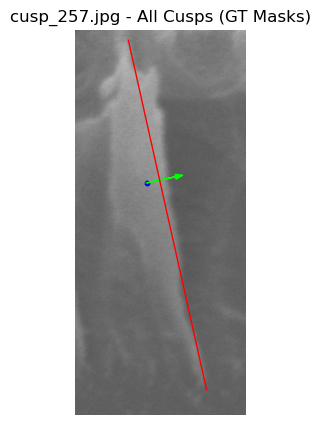

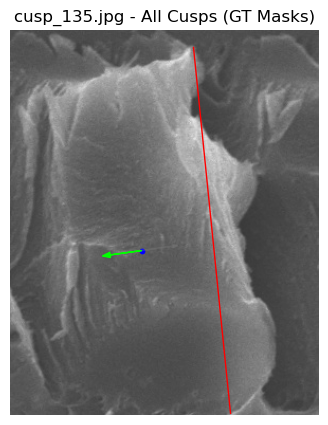

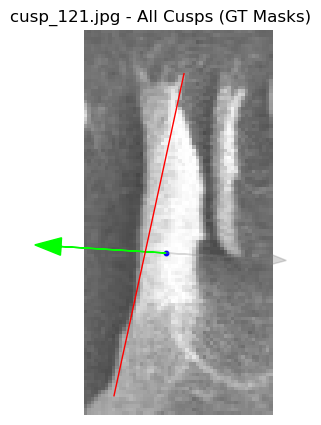

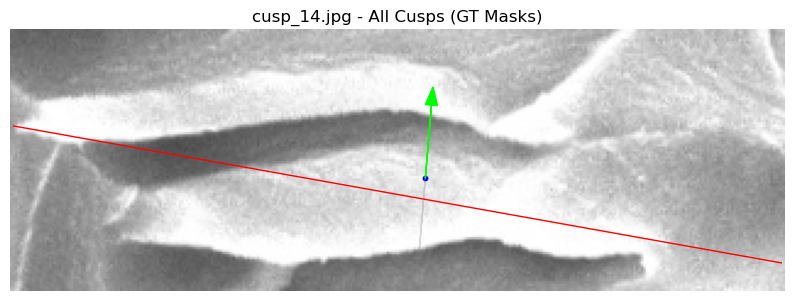

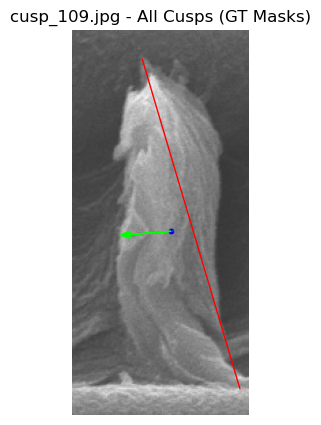

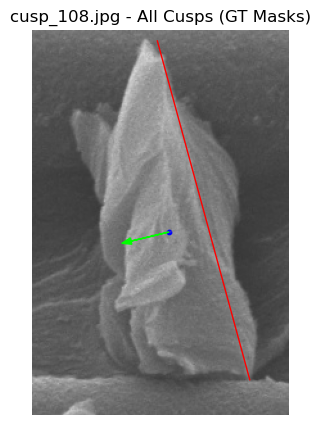

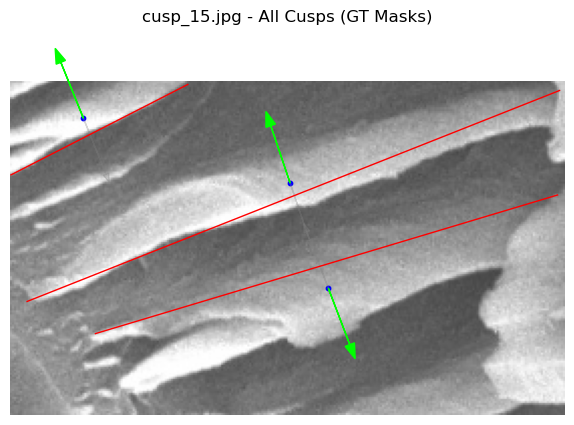

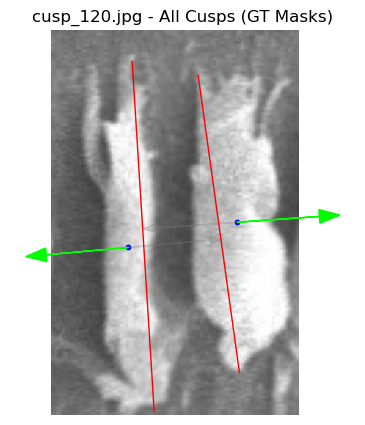

In [22]:
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from collections import defaultdict

# Group samples by image name
grouped_by_image = defaultdict(list)
for sample in all_cusps:
    grouped_by_image[sample["image_name"]].append(sample)

# Now plot one figure per image with all cusps
for image_name, samples in grouped_by_image.items():
    if not samples:
        continue

    # Compute Sobel from the first image sample (they all share the same one)
    gray_img = rgb2gray(samples[0]["image"]) * 255
    sobel_mag = compute_sobel_magnitude(gray_img)

    # Start figure
    plt.figure(figsize=(10, 5))
    plt.imshow(samples[0]["image"])
    scale_length = 30

    for sample in samples:
        v = sample["pca_direction"]
        u = np.array([-v[1], v[0]]) / np.linalg.norm([-v[1], v[0]])
        center = sample["center"]

        # Trace contrast
        sharp_edge_vector = trace_contrast_direction(center, u, sobel_mag)

        # PCA line
        base, tip = sample["centerline"]
        plt.plot([base[0], tip[0]], [base[1], tip[1]], 'r-', linewidth=1)

        # Center point
        plt.scatter(center[0], center[1], color='blue', s=10)

        # Show both perpendiculars (light gray)
        for sign in [+1, -1]:
            vec = sign * u * scale_length
            plt.arrow(center[0], center[1], vec[0], vec[1], head_width=3, color='gray', alpha=0.3)

        # Final chosen direction (lime)
        final_vec = sharp_edge_vector * scale_length
        plt.arrow(center[0], center[1], final_vec[0], final_vec[1], head_width=5, color='lime')

    plt.title(f"{image_name} - All Cusps (GT Masks)")
    plt.axis('off')
    plt.show()
